## Feature Extraction

In [72]:
import torch
from torch import nn
import torchaudio

from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import glob
import os
from os import makedirs
from os.path import join, basename, exists
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score
from speechpy.processing import cmvn, cmvnw

import torch
import torch.nn as nn
from torch.nn.functional import softmax
import torch.nn.functional as F
from models.EfficientNet import EfficientNet

In [73]:
from PyTorch_BayesianCNN.layers import BBBConv2d, BBBLinear

In [74]:
from PyTorch_BayesianCNN import metrics, utils
from PyTorch_BayesianCNN.layers.misc import FlattenLayer, ModuleWrapper

In [75]:
import PyTorch_BayesianCNN

In [76]:
import matplotlib.pyplot as plt

In [77]:
MEAN = []
STD = []

In [78]:
def cmvn_global(img1):
    # cropped = cropped - cropped.mean()
    # cropped = cropped / (cropped.std() + 1e-9)\
    # bs x mfcc x time
    m = img1.mean(axis=2)[:, :, np.newaxis]
    s = img1.std(axis=2)[:, :, np.newaxis]

    img1 -= m
    img1 /= s + 1e-9
    return img1

In [79]:
class SignalDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=False, min_max=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.STD = np.load("./std.npy")
        self.MEAN = np.load("./mean.npy")
        self.MIN = np.load('./min.npy')
        self.MAX = np.load('./max.npy')
        self.labels = pd.read_csv(csv_file)
        self.labels = self.labels.set_index('fname')
        
        self.files_names = list(self.labels.index)
        self.root_dir = root_dir
        self.transform = transform
        self.min_max = min_max
        self.files_names = [f for f in self.files_names if os.path.exists(join(self.root_dir, f+'.npy'))]

    def __len__(self):
        return len(self.files_names)

    def __getitem__(self, idx):
        features_idx = self.files_names[idx]

        features_name = join(self.root_dir,
                                features_idx+'.npy')
        features = np.load(features_name, allow_pickle=True)
#         features = features.astype(np.uint8)
        features = features[:, :2048]
        if self.transform:
            features = ((features.T - self.MEAN)/self.STD).T
        elif self.min_max:
            features = ((features.T - self.MIN) / (self.MAX - self.MIN)).T
        labels = self.labels.loc[features_idx, :]['encoded_labels']
        labels = np.array(labels)
        sample = {'features': torch.tensor(features).float(), 'labels': torch.tensor(labels).long()}

#         if self.transform:
#             sample = self.transform(sample)

        return sample

In [80]:
VAR2STD_EPSILON = 0.00001

### TODO: use rely after stat pooling?
### TODO: last layer do we need batchnorm/relu
class E_TDNN3(nn.Module):
    '''
    TODO: check input dimensions and structure and compare to that in https://github.com/hsn-zeinali/x-vector-kaldi-tf/blob/master/local/tf/models.py
    '''
    def __init__(self, num_classes, input_dim=23, dropout_keep_prob=0.5, activation='relu', enable_batch_norm=True, dropout_enable=True, dilation = True, batch_norm_momentum=0.05, batch_norm_eps=1e-03, mode='classification', backbone=False, params={}):
        super(E_TDNN3, self).__init__()
        '''
        frame level: number of convolutions = number of frames,
        input size = (128-batch size, 23 - mfcc feature size, 1935 ms - number of frames)
        '''
        '''
        design from http://www.danielpovey.com/files/2019_interspeech_xvector_refinement.pdf
        '''
        self.layer_sizes = [512, 512, 512, 512, 1500]
        self.layer_sizes = [64, 64, 64, 128]
        self.kernel_sizes = [5, 1, 3, 1]

        #self.strides = [1, 1, 1, 1, 1, 1, 1, 1, 1]
        self.strides = [1, 1, 1, 1, 1]
        #self.kernel_sizes = [7, 5, 1]
        self.embedding_sizes = [128]
        #self.embedding_sizes = [512]
        #self.embedding_sizes = [256, 256]
        #self.embedding_sizes = [64]
        self.dilation_rates = [1, 1, 2, 1, 3, 1, 4, 1, 1]
        self.dilation = dilation
        self.num_classes = num_classes
        self.input_feature_dim = input_dim
        self.dropout_keep_prob = dropout_keep_prob
        self.enable_batch_norm = enable_batch_norm
        self.dropout_enable = dropout_enable
        self.batch_norm_momentum = batch_norm_momentum
        self.batch_norm_eps = batch_norm_eps
        self.frame_level_conv_block_len = 0
        self.embeddings_block_len = 0
        self.activation = nn.ReLU()
        self.backbone = backbone
        if activation=='relu':
            self.activation = nn.ReLU()
        elif activation=='prelu':
            self.activation=nn.PRelu()
        elif activation=='lrelu':
            self.activation = nn.LeakyReLU(negative_slope=0.2)
        elif activation=='celu':
            self.activation = nn.SELU()
        '''
        frame level convolutional block
        '''
        prev_dim = self.input_feature_dim
        self.mode = mode

        self.frame_level_conv_block = nn.ModuleList([])
        # self.bn = nn.ModuleList([])
        for idx, (kernel_size, layer_size) in enumerate(zip(self.kernel_sizes, self.layer_sizes)):
            # TODO: same padding?
            # self.frame_level_conv_block.append(
            #     nn.Conv1d(prev_dim, layer_size, kernel_size, stride=1, padding=(kernel_size // 2), bias=0.1))
            # if self.enable_batch_norm:
            #     # TODO: affine
            #     self.bn.append(nn.BatchNorm1d(layer_size, affine=False))
            #TODO: Disacover the behavior of batchnorm and relu exchange
            print("check", prev_dim, layer_size, kernel_size, kernel_size // 2)
            if not self.dilation:
                self.frame_level_conv_block.append(
                     nn.Sequential(nn.Conv1d(prev_dim, layer_size, kernel_size, stride=1, padding=(kernel_size // 2), bias=0.1), self.activation, nn.BatchNorm1d(layer_size, affine=False)))
            else:
                self.frame_level_conv_block.append(
                    nn.Sequential(
                        nn.Conv1d(prev_dim, layer_size, kernel_size, dilation=self.dilation_rates[idx], stride=1, padding=(kernel_size // 2), bias=0.1),
                        self.activation, nn.BatchNorm1d(layer_size, eps=self.batch_norm_eps, momentum=self.batch_norm_momentum, affine=False)))
            ###########nn.init.kaiming_normal(self.frame_level_conv_block[-1][0].weight)
            prev_dim = layer_size
            self.frame_level_conv_block_len += 1

        prev_dim = prev_dim * 2
        #prev_dim = 2

        '''
        embedding layers
        '''
        self.embeddings_block = nn.ModuleList([])
        for i, out_dim in enumerate(self.embedding_sizes):
            self.embeddings_block.append(
                nn.Sequential(
                    nn.Linear(prev_dim, out_dim, bias=0.1),
                    self.activation,
                    nn.BatchNorm1d(out_dim, eps=self.batch_norm_eps, momentum=self.batch_norm_momentum, affine=True)
                ))
            #########nn.init.kaiming_normal(self.embeddings_block[-1][0].weight)
            prev_dim = out_dim
            self.embeddings_block_len+=1
        # if self.mode == 'classification':
        #     self.out = nn.Linear(prev_dim, num_classes, bias=0.1)
        # elif self.mode == 'angular':
        #     self.out = AngleLinear(prev_dim, num_classes, m, phiflag)
        self.out = nn.Linear(prev_dim, num_classes, **params)
        #self.classifier = nn.Softmax()
        self.dropout = nn.Dropout(self.dropout_keep_prob)
        ###########nn.init.kaiming_normal(self.out.weight)

    def forward(self, x, y=None, volatile=False):
        '''
        frame level
        '''
        x = x
        for idx in range(self.frame_level_conv_block.__len__()):
            #x = x.squeeze(1)
            x = self.frame_level_conv_block[idx](x)
            if self.dropout_enable:
                if idx!=len(self.kernel_sizes)-1:
                    x = self.dropout(x)


        '''
        statistic pooling
        '''

        mean, var = x.mean(dim=2), x.std(dim=2)

        x = torch.cat([mean, torch.sqrt(torch.add(var, VAR2STD_EPSILON)).float()], 1)

        '''
        embedding layer
        '''
        #TODO: Where place l2 after fitting the data to the layer,
        #        batchnorm, activation
        embs = []
        for idx in range(self.embeddings_block.__len__()):
            x = self.embeddings_block[idx](x)
            if idx == self.embeddings_block.__len__() - 1:
                embs.append(x)
            if idx == self.embeddings_block.__len__() - 2:
                embs.append(x)
            if self.dropout_enable:
                if idx!=len(self.kernel_sizes)-1:
                    x = self.dropout(x)
        
        if self.out is not None:
            x = self.out(x)
        if not volatile:
            return x
        else:
            return embs[-1], x

In [246]:
class DummyNetwork(nn.Module):
    def __init__(self):
        """
        conv: nn.Conv2d or BBBConv2d
        linear: nn.Linear or BBBLinear
        """
        super(DummyNetwork, self).__init__()
        self.num_classes = 41
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)

        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.5)
        
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        
        self.flat = nn.Flatten()
        
        # 33856 - должно соответствовать форме self.flat
        #self.fc1 = linear(1 * 1 * 64, outputs, alpha_shape=(1,1), bias=False, name='classifier')
        self.fc1 = nn.Linear(140576, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        #x = self.dropout1(x)
        
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        #x = self.dropout2(x)
        
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        return x

In [82]:
class DummyNetworkBBB(nn.Module):
    def __init__(self, conv, linear, num_classes=41, inputs = None, outputs = None, mode=''):
        """
        conv: nn.Conv2d or BBBConv2d
        linear: nn.Linear or BBBLinear
        """
        super(DummyNetworkBBB, self).__init__()
        params = {}
        self.num_classes = num_classes
        if mode=='b':
            params.update({'alpha_shape': (1, 1)})
    
        self.conv1 = conv(in_channels=1, out_channels=64, kernel_size=5, stride=2, bias=False, **params)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        #self.dropout1 = nn.Dropout(p=0.3)
        self.soft1 = nn.Softplus()
        
        self.conv2 = conv(in_channels=64, out_channels=64, kernel_size=3, stride=1, bias=False, **params)
        #self.dropout2 = nn.Dropout(p=0.3)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.soft2 = nn.Softplus()
        
        self.conv3 = conv(in_channels=64, out_channels=64, kernel_size=3, stride=1, bias=False, **params)
        self.dropout3 = nn.Dropout(p=0.3)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.soft3 = nn.Softplus()
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        #self.flat = nn.Flatten()
        
        self.flat = FlattenLayer(64 * 3 * 23)
        
        # 33856 - должно соответствовать форме self.flat
        #self.fc1 = linear(1 * 1 * 64, outputs, alpha_shape=(1,1), bias=False, name='classifier')
        self.classifier = linear(64 * 3 * 23, 41, bias=False, name='classifier', **params)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.soft1(x)
        x = self.mp(x)
        
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.soft2(x)
        x = self.mp(x)
        
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.soft3(x)
        x = self.mp(x)
        #x = self.dropout3(x)
    
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.classifier(x)

        kl = 0.0
        for module in self.modules():
            if hasattr(module, 'kl_loss'):
                kl = kl + module.kl_loss()
        return x, kl

In [83]:
class BBBAlexNet(ModuleWrapper):
    '''The architecture of AlexNet with Bayesian Layers'''

    def __init__(self, outputs, inputs):
        super(BBBAlexNet, self).__init__()

        self.num_classes = outputs

        self.conv1 = BBBConv2d(inputs, 64, 11, alpha_shape=(1,1), stride=4, padding=5, bias=False, name='conv1')
        self.soft1 = nn.Softplus()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(64, 192, 5, alpha_shape=(1,1), padding=2, bias=False, name='conv2')
        self.soft2 = nn.Softplus()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = BBBConv2d(192, 384, 3, alpha_shape=(1,1), padding=1, bias=False, name='conv3')
        self.soft3 = nn.Softplus()

        self.conv4 = BBBConv2d(384, 256, 3, alpha_shape=(1,1), padding=1, bias=False, name='conv4')
        self.soft4 = nn.Softplus()

        self.conv5 = BBBConv2d(256, 128, 3, alpha_shape=(1,1), padding=1, bias=False, name='conv5')
        self.soft5 = nn.Softplus()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = FlattenLayer(128* 2 * 3)
        self.classifier = BBBLinear(3 * 2 * 128, outputs, alpha_shape=(1,1), bias=False, name='classifier')


In [264]:
def validate(loader, model, criterion, kl_criterion=None, alpha=0.8, mode=''):
    model.eval()
    with torch.no_grad():
        loss_value = 0
        accuracy_value = 0
        kl_list = []
        for batch in tqdm(loader, total=loader.__len__()):
            labels, features = batch['labels'], batch['features']
            if isinstance(model, EfficientNet) \
            or isinstance(model, DummyNetwork) \
            or isinstance(model, DummyNetworkBBB) \
            or isinstance(model, BBBAlexNet):
                if isinstance(model, DummyNetwork) \
                or isinstance(model, DummyNetworkBBB) \
                or isinstance(model, BBBAlexNet):
                    features = features[:, :, :400]
                features = features.unsqueeze(1)
                if isinstance(model, EfficientNet):
                    features = features.repeat_interleave(3, axis=1)
            features_var = Variable(features).cuda(0)
            labels_var = Variable(labels).cuda(0)
            
            if mode=='b':
#                 outputs = torch.zeros(features_var.shape[0], model.num_classes, 1).cuda(0)
#                 kl = 0.0
#                 for j in range(1):
#                     out, _kl = model(features_var[:, :, :, :100])
#                     kl += _kl
#                     outputs[:, :, j] = F.log_softmax(out, dim=1)

#                 kl = kl / 1.0
#                 kl_list.append(kl.item())
#                 log_outputs = utils.logmeanexp(outputs, dim=2)

#                 loss_out = criterion(log_outputs, labels_var, kl)
                outputs = torch.zeros(features_var.shape[0], model.num_classes, 1).cuda(0)
                out = model(features_var)
                outputs[:, :, 0] = F.log_softmax(out, dim=1)
                log_outputs = utils.logmeanexp(outputs, dim=2)
            

                kl_loss = alpha*kl_criterion(model)
                loss_out = criterion(log_outputs, labels_var, kl_loss)
            elif mode=='bbb':
                out = model(features_var)
                kl_loss = alpha*kl_criterion(model)
                ce_loss = criterion(out, labels_var)
                loss_out = kl_loss+ce_loss
            else:
                out = model(features_var)
                loss_out = criterion(out, labels_var)
            
            loss_sing = loss_out.item()
            loss_value += loss_sing

            predicted_y = softmax(out, dim=1).data
            predicted_y = predicted_y.argmax(1)  # tupe of (array max elements, array indexes of max elements)
            #print("predicted", predicted_y.max())
            # print("labels", labels_var[:10])
            acc = predicted_y.eq(labels_var).float().mean().item()
            accuracy_value+=acc
    return accuracy_value/loader.__len__(), loss_value/loader.__len__()

In [274]:
def train(x_vec, train_dataset_loader, valid_dataset_loader, criterion, optimizer, kl_criterion=None, alpha=0.8, save_pth = '', mode=''):
    best_acc = 0
    for epoch in range(10000):
        loss_value = 0
        accuracy_value = 0
        kl_list = []
        for batch in tqdm(train_dataset_loader, total=train_dataset_loader.__len__()):
            labels, features = batch['labels'], batch['features']
            #features = features.reshape(features.shape[0], features.shape[1]*features.shape[2])
            if isinstance(x_vec, EfficientNet) \
            or isinstance(x_vec, DummyNetwork) \
            or isinstance(x_vec, DummyNetworkBBB) \
            or isinstance(x_vec, BBBAlexNet):
                if isinstance(x_vec, DummyNetwork) \
                or isinstance(x_vec, DummyNetworkBBB) \
                or isinstance(x_vec, BBBAlexNet):
                    features = features[:, :, :400]
                features = features.unsqueeze(1)
                if isinstance(x_vec, EfficientNet):
                    features = features.repeat_interleave(3, axis=1)
            features_var = Variable(features).cuda(0)
            labels_var = Variable(labels).cuda(0)
            
            if mode=='b':
#                 outputs = torch.zeros(features_var.shape[0], x_vec.num_classes, 1).cuda(0)
#                 kl = 0.0
#                 for j in range(0, 1):
#                     out, _kl = x_vec(features_var[:, :, :, :100])
#                     kl += _kl
#                     outputs[:, :, j] = F.log_softmax(out, dim=1)

#                 kl = kl / 1.0
#                 kl_list.append(kl.item())
#                 log_outputs = utils.logmeanexp(outputs, dim=2)
#                 loss_out = criterion(log_outputs, labels_var, kl)
                outputs = torch.zeros(features_var.shape[0], x_vec.num_classes, 1).cuda(0)
                out = x_vec(features_var)
                outputs[:, :, 0] = F.log_softmax(out, dim=1)
                log_outputs = utils.logmeanexp(outputs, dim=2)
            

                kl_loss = alpha*kl_criterion(x_vec)
                loss_out = criterion(log_outputs, labels_var, kl_loss)
            elif mode=='bbb':
                out = x_vec(features_var)
                kl_loss = alpha*kl_criterion(x_vec)
                ce_loss = criterion(out, labels_var)
                loss_out = kl_loss+ce_loss
                
            else:
                out = x_vec(features_var)
        #         knn.fit(features_var, labels)

                loss_out = criterion(out, labels_var)

            loss_out.backward()
            torch.nn.utils.clip_grad_norm_(x_vec.parameters(), 1)
            optimizer.step()
    #         if self.scheduler is not None and not isinstance(self.scheduler, torch.optim.lr_scheduler.MultiStepLR) and not isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
    #             # self.scheduler.batch_step()
    #             self.scheduler.step()
            #loss_value += loss.item()
            loss_sing = loss_out.item()
            loss_value += loss_sing

            predicted_y = softmax(out, dim=1).data
            predicted_y = predicted_y.argmax(1)  # tupe of (array max elements, array indexes of max elements)
            #print("predicted", predicted_y.max())
            # print("labels", labels_var[:10])
            acc = predicted_y.eq(labels_var).float().mean().item()
            accuracy_value+=acc
        acc_val, loss_val = validate(valid_dataset_loader, x_vec, criterion, kl_criterion=kl_criterion, alpha=alpha, mode=mode)
        if acc_val > best_acc:
            best_acc = acc_val
            model_state_dict = x_vec.state_dict()
            state = {
             'model': model_state_dict,
             'epoch': epoch,
             'optimizer': optimizer.state_dict()
             }
            torch.save(state, save_pth)
        print("Epoch {}, loss {}, acc {}, val loss {}, val acc {}".format(epoch, loss_value/train_dataset_loader.__len__(), 
                                                 accuracy_value/train_dataset_loader.__len__(), 
                                                  loss_val, acc_val))

### Prepare Features

In [86]:
parent_dir = "/home/gazizullina/Рабочий стол/ЦОС/log_mel/train/"

In [87]:
!rm -rf /home/gazizullina/Рабочий\ стол/ЦОС/log_mel/train/*.npy

In [88]:
wav_files = glob.glob("/home/gazizullina/Рабочий стол/ЦОС/audio_train/train/*.wav")

In [89]:
win_size = 2048

sample_rate = 11025
fft_size = 1024
overlap = 4
hop = fft_size // overlap
mels = 64
# In [8]:
# mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, 
#                           fmax=sample_rate//2)

In [122]:
specks = []
for i in tqdm(wav_files, total=len(wav_files)):
    name = basename(i)
   
    waveform, sample_rate = torchaudio.load(join("/home/gazizullina/Рабочий стол/ЦОС/audio_train/train/", name))
    #waveform_norm = cmvnw(waveform, win_size=301, variance_normalization=True)
    waveform = waveform
    if not exists(join(parent_dir, name)):
        makedirs(join(parent_dir, name))
    #transform_f = torchaudio.transforms.MelSpectrogram(n_fft=fft_size, hop_length=hop, n_mels=mels, f_max=sample_rate // 2)  
    #transform_f = torchaudio.transforms.MelSpectrogram(win_length=30, hop_length=20, n_mels=80, f_max=sample_rate // 2)
    transform_f = torchaudio.transforms.MelSpectrogram(hop_length=hop, n_mels=mels, f_max=sample_rate // 2, n_fft=fft_size)
    spectrogram = transform_f(torch.tensor(waveform))
    #print(spectrogram.shape)
    if spectrogram.shape[2]>100:
        if spectrogram.shape[2]< win_size:
            while spectrogram.shape[2] < win_size:
                    spectrogram = np.repeat(spectrogram, 2, axis=2)
        
        #spectrogram[spectrogram>1]=0
        #spectrogram=10000
        #spectrogram = np.log(spectrogram+1)
        #spectrogram*=100
        #spectrogram+=1
        #spectrogram = cmvn_global(spectrogram)
        #     spectrogram = spectrogram - spectrogram.mean()
        #     spectrogram = spectrogram / (spectrogram.std() + 1e-9)
        np.save(join(parent_dir, name+'.npy'), np.squeeze(spectrogram)[:, :2048])

  0%|          | 0/5683 [00:00<?, ?it/s]/home/gazizullina/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
100%|██████████| 5683/5683 [00:34<00:00, 164.98it/s]


In [374]:
# plt.hist(specks, bins='auto')

## Data Split

In [123]:
labels = pd.read_csv("/home/gazizullina/Рабочий стол/ЦОС/train.csv")

In [124]:
# labels['label'].values
# labels.head
# l = labels.set_index('fname')
# list(l.index)

In [125]:
labels_names = labels["label"].values

In [126]:
le = preprocessing.LabelEncoder()

In [127]:
encoded_labels = le.fit_transform(labels_names)

In [128]:
labels['encoded_labels'] = encoded_labels

In [129]:
len(np.unique(labels['encoded_labels'].values))

41

In [130]:
y_train, y_valid = train_test_split(labels, test_size=0.1, random_state=42)

In [131]:
len(np.unique(y_train['encoded_labels'].values))

41

In [132]:
y_valid, y_test = train_test_split(y_valid, test_size=0.3, random_state=42)

In [133]:
len(y_train), len(y_test), len(y_valid)

(5114, 171, 398)

In [134]:
y_train.to_csv("/home/gazizullina/Рабочий стол/ЦОС/labels_train.csv")
y_valid.to_csv("/home/gazizullina/Рабочий стол/ЦОС/labels_valid.csv")
y_test.to_csv("/home/gazizullina/Рабочий стол/ЦОС/labels_test.csv")


## Dataset

In [135]:
parent_dir = "/home/gazizullina/Рабочий стол/ЦОС/log_mel/train/"

In [136]:
y_train = "/home/gazizullina/Рабочий стол/ЦОС/labels_train.csv"
y_valid = "/home/gazizullina/Рабочий стол/ЦОС/labels_valid.csv"
y_test = "/home/gazizullina/Рабочий стол/ЦОС/labels_test.csv"

In [137]:
num_classes = len(np.unique(pd.read_csv(y_train)['label'].values))

In [138]:
train_dataset = SignalDataset(y_train, parent_dir)
valid_dataset = SignalDataset(y_valid, parent_dir)
test_dataset = SignalDataset(y_test, parent_dir)

In [139]:
# labels = pd.read_csv("/home/gazizullina/Рабочий стол/ЦОС/labels_train.csv")
# labels = labels.set_index('fname')

In [140]:
valid_dataset.__len__()

312

### Count Mean and STD

In [141]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=train_dataset.__len__(), shuffle=True,
                                             num_workers=1)

In [142]:
for batch in tqdm(train_dataset_loader, total=train_dataset_loader.__len__()):
        labels, features = batch['labels'], batch['features']
        #print(features.numpy().astype(np.uint8))
#         print(features.numpy().min(axis=(0, 2)), features.numpy().max(axis=(0, 2)))
#         np.save('./mean.npy', features.mean(axis=(0, 2)))
#         np.save('./std.npy', features.std(axis=(0, 2)))
#         np.save('./min.npy', features.numpy().min(axis=(0, 2)))
#         np.save('./max.npy', features.numpy().max(axis=(0, 2)))

100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


(array([5.03976122e+08, 1.78316000e+05, 4.96720000e+04, 1.79060000e+04,
        7.17600000e+03, 1.87600000e+03, 1.38200000e+03, 7.02000000e+02,
        5.84000000e+02, 2.48000000e+02]),
 array([1.5467380e-08, 1.2008826e+04, 2.4017652e+04, 3.6026477e+04,
        4.8035305e+04, 6.0044129e+04, 7.2052953e+04, 8.4061781e+04,
        9.6070609e+04, 1.0807943e+05, 1.2008826e+05], dtype=float32),
 <a list of 10 Patch objects>)

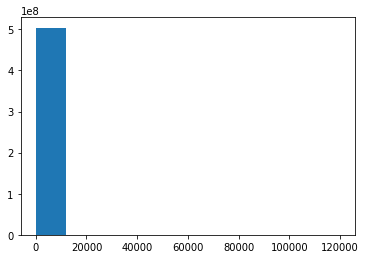

In [143]:
plt.hist(features[:, :, :].flatten())
# plt.xticks(range(20000))
# plt.show()

In [144]:
features[:, 8, :].max()

tensor(106983.1484)

In [145]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=128, shuffle=True,
                                             num_workers=1)

valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=valid_dataset.__len__(), shuffle=True,
                                             num_workers=4)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=test_dataset.__len__(), shuffle=True,
                                             num_workers=4)

### X Vector Model

In [103]:
best_acc = 0

In [227]:
x_vec = E_TDNN3(num_classes, input_dim=80, dropout_keep_prob=0.5,
                activation='relu', enable_batch_norm=True, dropout_enable=True, 
                dilation = True, batch_norm_momentum=0.05, batch_norm_eps=1e-03)

check 80 64 5 2
check 64 64 1 0
check 64 64 3 1
check 64 128 1 0


In [229]:
criterion = nn.CrossEntropyLoss()

In [247]:
optimizer = torch.optim.AdamW(x_vec.parameters(), lr=0.00001, weight_decay=1e-4, amsgrad=True)

#optimizer = torch.optim.SGD(x_vec.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4, nesterov=True)

In [248]:
x_vec.cuda(0)

E_TDNN3(
  (activation): ReLU()
  (frame_level_conv_block): ModuleList(
    (0): Sequential(
      (0): Conv1d(80, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): ReLU()
      (2): BatchNorm1d(64, eps=0.001, momentum=0.05, affine=False, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): BatchNorm1d(64, eps=0.001, momentum=0.05, affine=False, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), dilation=(2,))
      (1): ReLU()
      (2): BatchNorm1d(64, eps=0.001, momentum=0.05, affine=False, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): BatchNorm1d(128, eps=0.001, momentum=0.05, affine=False, track_running_stats=True)
    )
  )
  (embeddings_block): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=256, out_featu

In [ ]:
for epoch in range(10000):
    loss_value = 0
    accuracy_value = 0
    for batch in tqdm(train_dataset_loader, total=train_dataset_loader.__len__()):
        labels, features = batch['labels'], batch['features']
        #features = features.reshape(features.shape[0], features.shape[1]*features.shape[2])
        features_var = Variable(features).cuda(0)
        labels_var = Variable(labels).cuda(0)
        out = x_vec(features_var)
#         knn.fit(features_var, labels)
        
        loss_out = criterion(out, labels_var)
        
        
        loss_out.backward()
        torch.nn.utils.clip_grad_norm_(x_vec.parameters(), 1)
        optimizer.step()
#         if self.scheduler is not None and not isinstance(self.scheduler, torch.optim.lr_scheduler.MultiStepLR) and not isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
#             # self.scheduler.batch_step()
#             self.scheduler.step()
        #loss_value += loss.item()
        loss_sing = loss_out.item()
        loss_value += loss_sing

        predicted_y = softmax(out, dim=1).data
        predicted_y = predicted_y.argmax(1)  # tupe of (array max elements, array indexes of max elements)
        #print("predicted", predicted_y.max())
        # print("labels", labels_var[:10])
        acc = predicted_y.eq(labels_var).float().mean().item()
        accuracy_value+=acc
    acc_val, loss_val = validate(valid_dataset_loader, x_vec)
    if acc_val > best_acc:
        best_acc = acc_val
        model_state_dict = x_vec.state_dict()
        state = {
         'model': model_state_dict,
         'epoch': epoch,
         'optimizer': optimizer.state_dict()
         }
        torch.save(state, './best_model.pth')
    print("Epoch {}, loss {}, acc {}, val loss {}, val acc {}".format(epoch, loss_value/train_dataset_loader.__len__(), 
                                             accuracy_value/train_dataset_loader.__len__(), 
                                              loss_val, acc_val))

In [304]:
model_state_dict = x_vec.state_dict()
state = {'model': model_state_dict,
         'epoch': epoch,
         'optimizer': optimizer.state_dict(),

         #'EER': self.best_EER
         # 'scheduler': self.scheduler.state_dict(),
         # 'model_name': 'Extended'
         }
torch.save(state, './last_model_0.34.pth')

In [253]:
inference_model = E_TDNN3(num_classes, input_dim=80, dropout_keep_prob=0.5,
                activation='relu', enable_batch_norm=True, dropout_enable=True, 
                dilation = True, batch_norm_momentum=0.05, batch_norm_eps=1e-03)

check 80 64 5 2
check 64 64 1 0
check 64 64 3 1
check 64 128 1 0


In [254]:
dict_t = torch.load('./best_model.pth')
inference_model.load_state_dict(dict_t['model'])

<All keys matched successfully>

In [256]:
inference_model.cuda(0)
acc_test, loss_test = validate(test_dataset_loader, inference_model)
print(acc_test, loss_test)














  0%|          | 0/1 [00:00<?, ?it/s]












100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

0.49707603454589844 13.583440780639648


### Efficient Net B0

In [26]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=16, shuffle=True,
                                             num_workers=1)

valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=16, shuffle=True,
                                             num_workers=4)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=16, shuffle=True,
                                             num_workers=4)

In [27]:
eff_net = EfficientNet.from_name('efficientnet-b0', override_params={'num_classes':41, 'image_size': [80, 2048]})

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(eff_net.parameters(), lr=0.00001, weight_decay=1e-3, amsgrad=True)

#optimizer = torch.optim.SGD(x_vec.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4, nesterov=True)

In [161]:
dict_t = torch.load('./best_model_efficient_net.pth')
optimizer.load_state_dict(dict_t['optimizer'])

for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

eff_net.load_state_dict(dict_t['model'])

<All keys matched successfully>

In [163]:
eff_net.cuda(0)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [ ]:
model_eff = train(eff_net, train_dataset_loader, valid_dataset_loader, criterion, optimizer, save_pth='./best_model_efficient_net.pth')

In [29]:
inference_model_eff = EfficientNet.from_name('efficientnet-b0', override_params={'num_classes':41, 'image_size': [80, 2048]})
dict_t = torch.load('./best_model_efficient_net.pth')
inference_model_eff.load_state_dict(dict_t['model'])

<All keys matched successfully>

In [30]:
inference_model_eff.cuda(0)
acc_test, loss_test = validate(test_dataset_loader, inference_model_eff, criterion)
print(acc_test, loss_test)

100%|██████████| 11/11 [00:01<00:00,  9.82it/s]

0.4395661164413799 9.890928095037287


### Bayessian NN

In [186]:
train_dataset = SignalDataset(y_train, parent_dir)
valid_dataset = SignalDataset(y_valid, parent_dir)
test_dataset = SignalDataset(y_test, parent_dir)

In [187]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=16, shuffle=True,
                                             num_workers=1)

valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=16, shuffle=True,
                                             num_workers=4)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=16, shuffle=True,
                                             num_workers=4)

In [188]:
conv = nn.Conv2d
linear = nn.Linear
convbbb = BBBConv2d
linearbbb = BBBLinear

In [189]:
#model_orig = DummyNetwork(conv, linear)
model_bbb = DummyNetworkBBB(convbbb, linearbbb, mode='b')

In [190]:
alexnetbbb = BBBAlexNet(41, 1)

In [191]:
criterion_bbb = metrics.ELBO(train_dataset_loader.__len__()).cuda(0)
optimizer_bbb = torch.optim.Adam(alexnetbbb.parameters(), lr=0.000001)

In [ ]:
alexnetbbb.cuda(0)
alexnetbbb = train(alexnetbbb, train_dataset_loader, 
                  valid_dataset_loader, criterion_bbb, optimizer_bbb,
                  save_pth='./best_model_bbb_dummy.pth', mode='b')

In [26]:
criterion_bbb = metrics.ELBO(train_dataset_loader.__len__()).cuda(0)
optimizer_bbb = torch.optim.SGD(model_bbb.parameters(), lr=0.000001, weight_decay=1e-6)

In [ ]:
model_bbb.cuda(0)
model_bbb = train(model_bbb, train_dataset_loader, 
                  valid_dataset_loader, criterion_bbb, optimizer_bbb,
                  save_pth='./best_model_bbb_dummy.pth', mode='b')

### Bayessian Version 2

https://github.com/Harry24k/bayesian-neural-network-pytorch

Experiments here shows overfitting, which should not be the case for Neaural Networks employing Bayesian Back Prop

In [267]:
import torchbnn
import torchhk
from torchhk import transform_model

In [268]:
model = DummyNetwork()

In [269]:
transform_model(model, nn.Conv2d, torchbnn.BayesConv2d, 
                args={"prior_mu":0, "prior_sigma":0.1, "in_channels" : ".in_channels",
                      "out_channels" : ".out_channels", "kernel_size" : ".kernel_size",
                      "stride" : ".stride", "padding" : ".padding", "bias":".bias"
                     }, 
                attrs={"weight_mu" : ".weight"})
transform_model(model, nn.Linear, torchbnn.BayesLinear, 
            args={"prior_mu":0, "prior_sigma":0.1, "in_features" : ".in_features",
                  "out_features" : ".out_features", "bias":".bias"
                 }, 
            attrs={"weight_mu" : ".weight"})

DummyNetwork(
  (conv1): BayesConv2d(0, 0.1, 1, 32, kernel_size=(5, 5), stride=(2, 2))
  (conv2): BayesConv2d(0, 0.1, 32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): BayesConv2d(0, 0.1, 32, 32, kernel_size=(3, 3), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flat): Flatten()
  (fc1): Linear(in_features=140576, out_features=41, bias=True)
)

In [276]:
criterion = nn.CrossEntropyLoss()
criterion = metrics.ELBO(train_dataset_loader.__len__()).cuda(0)
kl_loss = torchbnn.BKLLoss(last_layer_only=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)


In [277]:
model.cuda(0)
model_bbb = train(model, train_dataset_loader, 
                  valid_dataset_loader, criterion, optimizer, kl_criterion=kl_loss,
                  save_pth='./best_model_bbb_dummy.pth', mode='b')

  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 0, loss 862.8161132305984, acc 0.09699170124481328, val loss 916.3891723632812, val acc 0.05


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 1, loss 851.3817219714406, acc 0.10736514522821576, val loss 880.9325622558594, val acc 0.065625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 2, loss 838.6619624854123, acc 0.11696058091286307, val loss 885.4332702636718, val acc 0.103125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 3, loss 842.7298280074883, acc 0.1084765856815077, val loss 860.9221160888671, val acc 0.10625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 4, loss 826.0871683334414, acc 0.12274007115868613, val loss 882.0614501953125, val acc 0.090625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 5, loss 829.5322475829065, acc 0.12396265560165975, val loss 859.1931671142578, val acc 0.11875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 6, loss 816.1291701447419, acc 0.133298755186722, val loss 849.101431274414, val acc 0.1


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 7, loss 820.6459158109926, acc 0.133298755186722, val loss 903.0398254394531, val acc 0.115625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 8, loss 809.735763866377, acc 0.13900414937759337, val loss 876.5821594238281, val acc 0.078125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 9, loss 804.7919263404434, acc 0.14522821576763487, val loss 833.7033477783203, val acc 0.096875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 10, loss 795.7696647169184, acc 0.14919235331636246, val loss 843.6142364501953, val acc 0.071875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 11, loss 794.8640650832307, acc 0.15534232365145229, val loss 847.0334106445313, val acc 0.146875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 12, loss 789.1504592578935, acc 0.15593509190557409, val loss 862.6789123535157, val acc 0.1


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 13, loss 781.8340507285724, acc 0.1735699466773583, val loss 824.5941925048828, val acc 0.115625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 14, loss 770.4524439894807, acc 0.1760521637453578, val loss 827.8815460205078, val acc 0.11875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 15, loss 770.8709623091448, acc 0.1743479549761135, val loss 855.322396850586, val acc 0.103125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 16, loss 755.4267889632229, acc 0.18349881451654237, val loss 809.8730346679688, val acc 0.134375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 17, loss 757.3002925888632, acc 0.1908713692946058, val loss 848.2519287109375, val acc 0.1375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 18, loss 755.3403901539402, acc 0.1908713692946058, val loss 832.5427093505859, val acc 0.121875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 19, loss 737.0753832298691, acc 0.19868850040237934, val loss 847.6228393554687, val acc 0.1625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 20, loss 742.3790075531639, acc 0.1986144044092582, val loss 834.5397491455078, val acc 0.1375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 21, loss 726.9544508051575, acc 0.2133224659688245, val loss 877.0653106689454, val acc 0.134375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 22, loss 741.1235891001847, acc 0.21435981036716478, val loss 799.5113250732422, val acc 0.16875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 23, loss 730.8829533113978, acc 0.2178052757785528, val loss 892.9780914306641, val acc 0.140625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 24, loss 723.1247806786502, acc 0.2161751630642602, val loss 828.4191436767578, val acc 0.16875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 25, loss 716.7355464444615, acc 0.23147599293977889, val loss 840.2298858642578, val acc 0.175


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 26, loss 717.7322448477211, acc 0.2251778304947857, val loss 834.6309539794922, val acc 0.1375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 27, loss 712.8785257299905, acc 0.24210877302276643, val loss 813.0340911865235, val acc 0.153125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 28, loss 706.502604124457, acc 0.2362551867219917, val loss 814.5747192382812, val acc 0.18125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 29, loss 700.866867508631, acc 0.23651452282157676, val loss 839.0472290039063, val acc 0.184375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 30, loss 700.0432643019807, acc 0.23736662717528362, val loss 821.959115600586, val acc 0.190625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 31, loss 696.171125609845, acc 0.23995998817113426, val loss 871.1886688232422, val acc 0.15


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 32, loss 693.0366917527068, acc 0.2550755780020195, val loss 891.523062133789, val acc 0.159375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 33, loss 687.798735305976, acc 0.26455986969698514, val loss 852.9121612548828, val acc 0.16875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 34, loss 689.4465229461797, acc 0.26426348547717843, val loss 890.2366729736328, val acc 0.18125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 35, loss 681.8107792391322, acc 0.2684869591254911, val loss 828.9306091308594, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 36, loss 674.2340087890625, acc 0.272377000619267, val loss 858.0424377441407, val acc 0.1625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 37, loss 674.6066848944827, acc 0.2764152342847769, val loss 858.7051879882813, val acc 0.209375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 38, loss 673.8934272987714, acc 0.2796384114076488, val loss 850.7723419189454, val acc 0.2125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 39, loss 671.9402074536841, acc 0.2721917605746336, val loss 869.3910339355468, val acc 0.184375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 40, loss 667.5754109616101, acc 0.2836766450731586, val loss 894.4966339111328, val acc 0.178125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 41, loss 657.6179470204713, acc 0.2854179016534718, val loss 837.5428314208984, val acc 0.19375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 42, loss 659.3375631625227, acc 0.29619887384636273, val loss 863.272103881836, val acc 0.18125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 43, loss 645.2839251633008, acc 0.3002741554466026, val loss 895.3485733032227, val acc 0.2


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 44, loss 651.1977844238281, acc 0.3019413159719641, val loss 879.0943389892578, val acc 0.1875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 45, loss 644.2765868887367, acc 0.3070168940358142, val loss 870.9803527832031, val acc 0.2


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 46, loss 646.4282501347332, acc 0.3039419087136929, val loss 866.4877136230468, val acc 0.175


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 47, loss 632.6879547245769, acc 0.31413011265246205, val loss 892.2077239990234, val acc 0.159375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 48, loss 641.5900978943124, acc 0.3156490813152424, val loss 835.97294921875, val acc 0.209375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 49, loss 631.0672946787474, acc 0.31550088920533903, val loss 861.9064331054688, val acc 0.20625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 50, loss 632.9705685184209, acc 0.3197984589086034, val loss 953.5902099609375, val acc 0.2125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 51, loss 627.0417542516938, acc 0.318427682417557, val loss 929.4141510009765, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 52, loss 633.3817507162133, acc 0.3281342620300554, val loss 876.1430267333984, val acc 0.159375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 53, loss 631.0770856295384, acc 0.3251704210067686, val loss 893.2134902954101, val acc 0.171875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 54, loss 613.8887778634353, acc 0.335988441072559, val loss 890.2926849365234, val acc 0.20625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 55, loss 623.9906102097381, acc 0.3367294013747536, val loss 911.8053283691406, val acc 0.175


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 56, loss 606.3127062785675, acc 0.3411751630642602, val loss 857.6517150878906, val acc 0.225


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 57, loss 611.13007668143, acc 0.33313574397712326, val loss 870.0284210205078, val acc 0.21875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 58, loss 604.2669409280991, acc 0.3441390041493776, val loss 933.4816772460938, val acc 0.215625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 59, loss 608.025244621815, acc 0.3440278601596959, val loss 950.7458618164062, val acc 0.190625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 60, loss 606.3348688782498, acc 0.338767042113043, val loss 979.7748504638672, val acc 0.175


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 61, loss 595.4088355100007, acc 0.35377148795424657, val loss 927.0289581298828, val acc 0.20625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 62, loss 595.5362222125422, acc 0.35347510373443985, val loss 900.6302032470703, val acc 0.20625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 63, loss 597.0859558611985, acc 0.3644042680372341, val loss 926.0671447753906, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 64, loss 580.5793346864059, acc 0.3657750445282805, val loss 900.5068725585937, val acc 0.215625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 65, loss 590.6408840828417, acc 0.3619961471478474, val loss 898.4250091552734, val acc 0.20625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 66, loss 583.3577544659499, acc 0.3631446354740388, val loss 898.7990264892578, val acc 0.20625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 67, loss 586.9455946293115, acc 0.3744442799279304, val loss 920.1358825683594, val acc 0.19375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 68, loss 580.9834768208231, acc 0.37722288090658385, val loss 937.2324279785156, val acc 0.2


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 69, loss 570.4759353067865, acc 0.37677830482419594, val loss 928.7424011230469, val acc 0.2


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 70, loss 578.1789131639409, acc 0.37385151161197805, val loss 897.4095520019531, val acc 0.196875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 71, loss 571.8645142361336, acc 0.38681831659123117, val loss 972.9617095947266, val acc 0.18125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 72, loss 573.8629068081805, acc 0.37981624190243446, val loss 899.6635452270508, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 73, loss 566.9627486739416, acc 0.39622851229307565, val loss 891.5398468017578, val acc 0.209375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 74, loss 564.0329687348045, acc 0.393190575091176, val loss 880.0775695800781, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 75, loss 550.0788116455078, acc 0.3993405454880964, val loss 937.2395477294922, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 76, loss 561.0807877536631, acc 0.39622851229307565, val loss 934.4679656982422, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 77, loss 553.9217234251411, acc 0.4005631298692395, val loss 918.7346984863282, val acc 0.20625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 78, loss 554.3198912054671, acc 0.4069353883691843, val loss 966.1391082763672, val acc 0.19375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 79, loss 555.163133676616, acc 0.4039344991638453, val loss 1021.6404602050782, val acc 0.2


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 80, loss 545.0360833005786, acc 0.4148266153464179, val loss 948.0305389404297, val acc 0.19375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 81, loss 541.9705957436463, acc 0.40797273276752455, val loss 973.9699462890625, val acc 0.196875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 82, loss 554.7022541726773, acc 0.4112700060690092, val loss 968.1150360107422, val acc 0.2


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 83, loss 546.7630924209025, acc 0.41212211036088553, val loss 908.8404510498046, val acc 0.20625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 84, loss 537.8061253717826, acc 0.41290011865964077, val loss 954.5679931640625, val acc 0.2


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 85, loss 530.6280694225517, acc 0.4174199763422685, val loss 967.4716522216797, val acc 0.196875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 86, loss 534.8204757247229, acc 0.4282379964698894, val loss 969.3988677978516, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 87, loss 527.8997401320588, acc 0.42364404273231, val loss 1037.1896881103517, val acc 0.20625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 88, loss 525.9827022315061, acc 0.4307202135378889, val loss 934.3291046142579, val acc 0.2125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 89, loss 533.7475858822897, acc 0.42620035573160003, val loss 955.773974609375, val acc 0.21875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 90, loss 518.55800733131, acc 0.43372110261956687, val loss 969.2510131835937, val acc 0.215625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 91, loss 511.6703704580726, acc 0.43687018381114817, val loss 1050.5418670654296, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 92, loss 517.5649035441925, acc 0.44609513940652873, val loss 968.053921508789, val acc 0.215625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 93, loss 511.75674843689217, acc 0.442797866105044, val loss 1020.5460540771485, val acc 0.21875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 94, loss 510.9087068549825, acc 0.4440945466029693, val loss 991.579833984375, val acc 0.23125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 95, loss 501.7297613373436, acc 0.4521339656901063, val loss 990.8607040405274, val acc 0.23125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 96, loss 504.3766570665035, acc 0.4447984589086034, val loss 1036.4748291015626, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 97, loss 515.5716814856312, acc 0.45042975710635363, val loss 1027.6756408691406, val acc 0.196875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 98, loss 499.19764690478314, acc 0.44902193249508554, val loss 1038.6303649902343, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 99, loss 493.4295595414411, acc 0.45717249569556523, val loss 1065.674786376953, val acc 0.21875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 100, loss 498.1026214979496, acc 0.4643227623706042, val loss 1029.8232208251952, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 101, loss 496.81769919494377, acc 0.4631372259860217, val loss 959.6864562988281, val acc 0.21875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 102, loss 493.9219528134928, acc 0.4672866035793827, val loss 1030.7052154541016, val acc 0.215625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 103, loss 489.78184642237744, acc 0.46580468297499344, val loss 955.3713836669922, val acc 0.225


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 104, loss 490.36055150961977, acc 0.4703986367744034, val loss 1095.0816772460937, val acc 0.2125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 105, loss 488.84600443859813, acc 0.4691019562764781, val loss 1052.151626586914, val acc 0.225


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 106, loss 485.5699759835524, acc 0.4742145821513971, val loss 1061.241519165039, val acc 0.21875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 107, loss 478.8484546455605, acc 0.47628927094807766, val loss 1087.5904327392577, val acc 0.21875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 108, loss 476.8550130123914, acc 0.47343657385264193, val loss 1086.2274810791016, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 109, loss 477.07210334999434, acc 0.47417753415483654, val loss 1065.462550354004, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 110, loss 476.3774368476076, acc 0.4790308240538316, val loss 1092.9985412597657, val acc 0.234375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 111, loss 472.4907905926843, acc 0.48647747494867727, val loss 1038.704916381836, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 112, loss 462.5743804551754, acc 0.48995998817113423, val loss 1078.337255859375, val acc 0.234375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 113, loss 469.9563164295497, acc 0.48640337883189505, val loss 1093.3351776123047, val acc 0.209375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 114, loss 451.31878041627493, acc 0.5008150564189768, val loss 1140.8327056884766, val acc 0.21875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 115, loss 457.8530516565093, acc 0.5022228809065838, val loss 1166.1477828979491, val acc 0.209375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 116, loss 471.49932753693514, acc 0.49918494382834533, val loss 1048.4839996337892, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 117, loss 452.52617198896604, acc 0.506890930699115, val loss 1102.002230834961, val acc 0.209375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 118, loss 454.6802510621637, acc 0.5025563131229511, val loss 1128.6203216552735, val acc 0.215625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 119, loss 443.680139976913, acc 0.5114107883817427, val loss 1026.9699249267578, val acc 0.234375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 120, loss 445.6100697497609, acc 0.511299644392061, val loss 1158.4000579833985, val acc 0.2


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 121, loss 443.56782462092355, acc 0.5125963248899863, val loss 1151.2752075195312, val acc 0.221875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 122, loss 446.75263267928636, acc 0.5158565501949105, val loss 1133.4896591186523, val acc 0.21875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 123, loss 436.0201357766306, acc 0.5266004742675797, val loss 1046.413671875, val acc 0.21875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 124, loss 450.0470853623513, acc 0.5148192057965703, val loss 1211.0747100830079, val acc 0.215625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 125, loss 434.905009542758, acc 0.5251185537868516, val loss 1143.1682037353517, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 126, loss 426.44095162039474, acc 0.5308980439708441, val loss 1164.0836212158204, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 127, loss 435.3355289949916, acc 0.539196799157566, val loss 1120.6549041748046, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 128, loss 423.043205989347, acc 0.5386040309652748, val loss 1153.3611602783203, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 129, loss 432.0179620639912, acc 0.536455246051812, val loss 1212.1681350708009, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 130, loss 424.6159928824397, acc 0.5404934796554913, val loss 1176.414584350586, val acc 0.221875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 131, loss 419.474906161613, acc 0.541679016287396, val loss 1266.8240310668946, val acc 0.203125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 132, loss 417.7432547604889, acc 0.5362700060690092, val loss 1166.354067993164, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 133, loss 412.8188734252423, acc 0.5449021933484374, val loss 1163.4700469970703, val acc 0.225


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 134, loss 408.2170093583863, acc 0.5450503855820019, val loss 1316.3815704345702, val acc 0.19375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 135, loss 404.1420855383655, acc 0.5644264968104382, val loss 1222.1698150634766, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 136, loss 414.4777727562362, acc 0.5570909900289354, val loss 1134.3658172607422, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 137, loss 409.9520185161923, acc 0.5530527564252561, val loss 1197.516390991211, val acc 0.196875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 138, loss 412.45579826386637, acc 0.551830172044113, val loss 1136.354443359375, val acc 0.234375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 139, loss 404.18534363552743, acc 0.5673532901463172, val loss 1147.5040740966797, val acc 0.225


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 140, loss 391.7157966012282, acc 0.5671310019196316, val loss 1264.7420593261718, val acc 0.21875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 141, loss 392.98770787409234, acc 0.5649451690096083, val loss 1174.8546203613282, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 142, loss 394.311522107896, acc 0.5646117369169021, val loss 1190.4613891601562, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 143, loss 382.39223834785685, acc 0.5769857737038641, val loss 1238.3933334350586, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 144, loss 392.14540429332936, acc 0.5715397156125777, val loss 1345.1654296875, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 145, loss 383.82305129435053, acc 0.5797643746825175, val loss 1228.6260009765624, val acc 0.234375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 146, loss 390.3115077988241, acc 0.5739478365019643, val loss 1258.8587341308594, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 147, loss 372.9866907586695, acc 0.5867294013747536, val loss 1284.8412872314452, val acc 0.23125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 148, loss 378.2009185221185, acc 0.5747258448007195, val loss 1328.6845825195312, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 149, loss 380.2508523711525, acc 0.5866553053816325, val loss 1265.9892883300781, val acc 0.215625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 150, loss 379.08585072750867, acc 0.5896561947106326, val loss 1319.4360519409179, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 151, loss 374.39853171194244, acc 0.593138707871259, val loss 1274.3005920410155, val acc 0.234375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 152, loss 373.59746105146604, acc 0.5982513338698391, val loss 1382.3603393554688, val acc 0.21875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 153, loss 370.90241326929623, acc 0.6011781269583959, val loss 1434.2732360839843, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 154, loss 361.63108513068363, acc 0.5985847659625453, val loss 1334.7703399658203, val acc 0.2125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 155, loss 364.3961213931008, acc 0.6002148785531768, val loss 1363.6144226074218, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 156, loss 361.6428527832031, acc 0.6037714879542465, val loss 1284.5898010253907, val acc 0.278125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 157, loss 353.8448091878931, acc 0.6090693539356296, val loss 1322.7957489013672, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 158, loss 361.04060993748584, acc 0.6064389449432183, val loss 1413.038247680664, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 159, loss 355.2937584714771, acc 0.6103289864369943, val loss 1374.9139389038087, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 160, loss 362.14571807987954, acc 0.6065130411836617, val loss 1428.0882598876954, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 161, loss 349.46826773362534, acc 0.6228512154575205, val loss 1414.0068237304688, val acc 0.21875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 162, loss 346.2393134342684, acc 0.622443687124371, val loss 1468.1146606445313, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 163, loss 348.2383139835848, acc 0.6225918793579355, val loss 1367.5898010253907, val acc 0.234375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 164, loss 347.4013045061673, acc 0.6166271490674791, val loss 1378.7014862060546, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 165, loss 347.32906180100815, acc 0.6229253112033195, val loss 1410.980661010742, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 166, loss 340.660930047886, acc 0.629075281847562, val loss 1407.098211669922, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 167, loss 334.0801212421591, acc 0.628815945747977, val loss 1471.926968383789, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 168, loss 347.18507622683194, acc 0.630297866105044, val loss 1515.4423431396485, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 169, loss 340.02817171342144, acc 0.6332617073138225, val loss 1569.0069671630858, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 170, loss 322.4129472629658, acc 0.6415604625005445, val loss 1578.8872955322265, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 171, loss 337.0216438325114, acc 0.6355586843371885, val loss 1430.0411834716797, val acc 0.23125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 172, loss 331.7595276575365, acc 0.6324466511421678, val loss 1456.1511108398438, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 173, loss 330.55255111124507, acc 0.6454505039943205, val loss 1591.6229125976563, val acc 0.234375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 174, loss 334.9753665528357, acc 0.6398192057965703, val loss 1591.9891342163087, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 175, loss 325.97705442183246, acc 0.651489330277898, val loss 1592.447801208496, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 176, loss 315.79920538431384, acc 0.6547495557064832, val loss 1582.3196746826172, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 177, loss 311.9397748891743, acc 0.6570094843623054, val loss 1590.9142578125, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 178, loss 324.65526130486325, acc 0.6482291049729739, val loss 1638.839892578125, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 179, loss 315.3594337558351, acc 0.6573799645752333, val loss 1573.0634552001952, val acc 0.225


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 180, loss 312.81582609944326, acc 0.6585655009598158, val loss 1576.1352142333985, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 181, loss 306.5813017564196, acc 0.664196799157566, val loss 1586.858139038086, val acc 0.21875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 182, loss 310.77649921401405, acc 0.6673088323525868, val loss 1634.634085083008, val acc 0.23125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 183, loss 299.24059024984905, acc 0.6711247778532416, val loss 1538.0529754638671, val acc 0.23125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 184, loss 304.4327599141608, acc 0.6723103142378242, val loss 1587.0382720947266, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 185, loss 304.18477693929714, acc 0.6643449913911305, val loss 1602.2300750732422, val acc 0.215625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 186, loss 311.5800548965011, acc 0.6629742146527619, val loss 1715.159490966797, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 187, loss 302.4238323037555, acc 0.6736069947357495, val loss 1622.1234344482423, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 188, loss 291.8642112763591, acc 0.6784602846347445, val loss 1710.6629608154296, val acc 0.28125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 189, loss 295.71471002982366, acc 0.6770895081436981, val loss 1820.2234161376953, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 190, loss 296.6782899278823, acc 0.6796458212666492, val loss 1722.585269165039, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 191, loss 293.83876464970376, acc 0.6807572614107884, val loss 1837.5472412109375, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 192, loss 281.8040406001554, acc 0.6915011856071187, val loss 1534.708935546875, val acc 0.278125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 193, loss 285.1414753767465, acc 0.6893524008173171, val loss 1688.2686737060546, val acc 0.20625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 194, loss 284.122007979397, acc 0.6826837582212266, val loss 1705.3226226806642, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 195, loss 287.8522793623422, acc 0.6877963842198067, val loss 1686.6013732910155, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 196, loss 274.01429166041964, acc 0.6893524008173171, val loss 1692.3163116455078, val acc 0.225


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 197, loss 284.00323969101015, acc 0.6922791939058739, val loss 1686.7354827880858, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 198, loss 272.3771814370056, acc 0.7023933017896914, val loss 1685.13896484375, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 199, loss 277.9684942253398, acc 0.6946132188021394, val loss 1787.75771484375, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 200, loss 277.9695830681512, acc 0.7018746295905212, val loss 1806.338690185547, val acc 0.23125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 201, loss 278.784943671642, acc 0.6971324838048689, val loss 1821.142642211914, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 202, loss 271.65357167097545, acc 0.6987625963955004, val loss 1876.842123413086, val acc 0.221875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 203, loss 266.6484447732506, acc 0.7109513930759984, val loss 1804.15068359375, val acc 0.23125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 204, loss 262.92967402984493, acc 0.7100992887841221, val loss 1820.3826782226563, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 205, loss 267.7372527696285, acc 0.712062833714782, val loss 1852.7945190429687, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 206, loss 261.01624144558093, acc 0.7093583284200969, val loss 1840.559518432617, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 207, loss 271.28282983075536, acc 0.7083580320801478, val loss 1814.5379028320312, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 208, loss 258.13577118553064, acc 0.7187314760635503, val loss 1800.954901123047, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 209, loss 272.1562796865756, acc 0.7060610551804428, val loss 1962.651693725586, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 210, loss 263.94691654062865, acc 0.7223621814577411, val loss 1823.5616912841797, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 211, loss 257.554701888215, acc 0.7182869001048234, val loss 1977.544857788086, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 212, loss 255.12101807337083, acc 0.7210655009598158, val loss 1897.194644165039, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 213, loss 253.86644270014466, acc 0.7258076469927902, val loss 1907.36396484375, val acc 0.234375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 214, loss 256.21290694430655, acc 0.7229549498973545, val loss 1929.7329162597657, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 215, loss 251.65285536263494, acc 0.7275489034494423, val loss 1963.58544921875, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 216, loss 253.4750457383785, acc 0.730142264445293, val loss 1949.4986755371094, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 217, loss 246.66435458551305, acc 0.7336247778532416, val loss 2107.26403503418, val acc 0.23125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 218, loss 248.15749742183448, acc 0.7334395377467777, val loss 2048.277035522461, val acc 0.23125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 219, loss 243.27120628198648, acc 0.7316982810428033, val loss 1847.9108825683593, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 220, loss 235.8805378007691, acc 0.7444057499224714, val loss 1951.3783813476562, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 221, loss 246.78117525725938, acc 0.7376630113332598, val loss 2190.9465423583983, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 222, loss 234.82146062890524, acc 0.7405157084286955, val loss 2027.9204803466796, val acc 0.284375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 223, loss 242.6966820158899, acc 0.7309202727440481, val loss 2279.5173278808593, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 224, loss 245.14993533059274, acc 0.7448132780082988, val loss 2161.0874786376953, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 225, loss 238.0133899079319, acc 0.7381075875393088, val loss 2192.619415283203, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 226, loss 239.47129471964857, acc 0.7414789568339146, val loss 2111.1574645996093, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 227, loss 237.17741481100376, acc 0.7486662716291752, val loss 2167.0566497802733, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 228, loss 226.74379675615873, acc 0.7525933609958506, val loss 2128.1676696777345, val acc 0.28125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 229, loss 226.18868324469727, acc 0.7522599291504666, val loss 2116.6567352294924, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 230, loss 221.0442170898944, acc 0.7547791939058739, val loss 2332.388531494141, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 231, loss 224.20189391973108, acc 0.7581505632004797, val loss 2371.9158828735353, val acc 0.278125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 232, loss 233.41467569848808, acc 0.7577059872417529, val loss 2255.900598144531, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 233, loss 227.45774045326897, acc 0.7516671607108532, val loss 2373.5014137268067, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 234, loss 218.79905305759542, acc 0.7607439241963303, val loss 2313.2854095458983, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 235, loss 222.8393829314046, acc 0.7586692353996498, val loss 2391.9427001953127, val acc 0.234375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 236, loss 219.61083901670463, acc 0.7650414937759336, val loss 2371.3352752685546, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 237, loss 214.47900424656532, acc 0.762114700934699, val loss 2287.208123779297, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 238, loss 221.35234149758747, acc 0.767486662785542, val loss 2342.6657379150392, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 239, loss 215.4207037454819, acc 0.764226437604279, val loss 2377.511151123047, val acc 0.278125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 240, loss 225.3650450884554, acc 0.7623740370342841, val loss 2277.1463958740233, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 241, loss 217.50080563814313, acc 0.7677459988851271, val loss 2401.8127868652346, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 242, loss 209.70162812703873, acc 0.7682646710842972, val loss 2455.737423706055, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 243, loss 220.74394886523362, acc 0.7603734439834025, val loss 2265.5365966796876, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 244, loss 215.20315398418063, acc 0.7613366926359438, val loss 2203.991778564453, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 245, loss 211.78063856813424, acc 0.7710062240663901, val loss 2424.9272857666015, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 246, loss 212.1663689118698, acc 0.7750074096735088, val loss 2590.216357421875, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 247, loss 211.4489543131278, acc 0.7737848254160268, val loss 2343.3506591796877, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 248, loss 212.76407773069326, acc 0.7808609958506224, val loss 2285.379034423828, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 249, loss 211.4910047778945, acc 0.7732661532168567, val loss 2219.668664550781, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 250, loss 213.2748745328658, acc 0.7713026082861968, val loss 2279.507174682617, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 251, loss 213.26597762800353, acc 0.7774155308102176, val loss 2413.3898803710936, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 252, loss 204.8593360061962, acc 0.7786381150676996, val loss 2663.057777404785, val acc 0.23125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 253, loss 199.27514559401516, acc 0.7836395972002591, val loss 2444.7981842041017, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 254, loss 206.1496858611641, acc 0.7743034976151969, val loss 2403.44375, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 255, loss 211.86871909897357, acc 0.7752667457730938, val loss 2600.614651489258, val acc 0.2875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 256, loss 199.41000330843866, acc 0.785232661670669, val loss 2408.05322265625, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 257, loss 214.36668183101165, acc 0.7760818020684096, val loss 2578.074136352539, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 258, loss 199.3598710016591, acc 0.7814908121631353, val loss 2590.469747924805, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 259, loss 199.21836485803374, acc 0.7888263191919603, val loss 2483.919479370117, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 260, loss 204.48639359612682, acc 0.7830468287606457, val loss 2532.8249572753907, val acc 0.29375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 261, loss 202.5799820175804, acc 0.787529638694035, val loss 2640.227471923828, val acc 0.234375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 262, loss 194.31586534650495, acc 0.7849362776981844, val loss 2654.666696166992, val acc 0.234375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 263, loss 196.26015811070366, acc 0.7943464730290456, val loss 2746.56142578125, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 264, loss 187.6383744915986, acc 0.7891597510373444, val loss 2754.379931640625, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 265, loss 196.81027504913044, acc 0.7938278008298755, val loss 2516.512322998047, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 266, loss 188.91390353614364, acc 0.7986069947357495, val loss 2627.3999450683596, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 267, loss 189.14633659109535, acc 0.7909751037344398, val loss 2527.5212890625, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 268, loss 194.1618566552633, acc 0.7966064021795123, val loss 2691.8406005859374, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 269, loss 184.70879238374005, acc 0.7985328987426283, val loss 2744.102850341797, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 270, loss 189.9515563363356, acc 0.7932350328849065, val loss 2784.706448364258, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 271, loss 189.35217479378355, acc 0.7983476586361644, val loss 2627.0507476806642, val acc 0.284375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 272, loss 182.94333470411814, acc 0.795569057781172, val loss 2739.8933685302736, val acc 0.290625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 273, loss 187.15006593450966, acc 0.8000518672199171, val loss 2643.9580810546877, val acc 0.234375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 274, loss 184.7762467732568, acc 0.8034232365145229, val loss 2920.1209411621094, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 275, loss 182.5189723355147, acc 0.8023117963703836, val loss 2727.7790863037108, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 276, loss 188.6912451411184, acc 0.794050089056561, val loss 2731.3440673828127, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 277, loss 187.80903636568314, acc 0.8008669236388939, val loss 2967.4710693359375, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 278, loss 197.60992345448847, acc 0.799792531120332, val loss 2845.843719482422, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 279, loss 182.04007567409658, acc 0.8017931241712135, val loss 2767.7858795166017, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 280, loss 184.94506827627475, acc 0.8049051573662342, val loss 2671.0408142089846, val acc 0.278125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 281, loss 184.45796735059176, acc 0.80068168353243, val loss 2709.096502685547, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 282, loss 186.0241410996904, acc 0.8037937167274507, val loss 2857.257781982422, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 283, loss 187.55171290274973, acc 0.8032750445282806, val loss 3052.3198364257814, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 284, loss 183.22491497023967, acc 0.804831061125791, val loss 2940.5620025634767, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 285, loss 179.16070977632435, acc 0.8126111441133428, val loss 2904.9828918457033, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 286, loss 175.8591067701949, acc 0.8129445764533711, val loss 3273.0399627685547, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 287, loss 179.35605748189437, acc 0.8100918793579355, val loss 3034.4804809570314, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 288, loss 173.71191244056115, acc 0.8179460580912863, val loss 2949.45673828125, val acc 0.23125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 289, loss 172.58356210700703, acc 0.8084617665199818, val loss 2783.629669189453, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 290, loss 169.85950465667298, acc 0.8158713692946058, val loss 3011.8560943603516, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 291, loss 171.38769454580125, acc 0.8183906345446574, val loss 2893.6654724121095, val acc 0.284375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 292, loss 178.6875024892977, acc 0.8111292237562757, val loss 3298.8705474853514, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 293, loss 178.31088017526997, acc 0.8157972735488068, val loss 3083.015704345703, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 294, loss 172.4974638614417, acc 0.8180572022046291, val loss 3281.069958496094, val acc 0.23125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 295, loss 170.9942094986617, acc 0.8181312984450724, val loss 2983.6228759765627, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 296, loss 181.6062897785076, acc 0.8142412569512965, val loss 2976.8468322753906, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 297, loss 166.34250856905064, acc 0.8202059872417529, val loss 3109.3582458496094, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 298, loss 173.12228554907676, acc 0.8174644340123378, val loss 3088.241226196289, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 299, loss 166.61004033128256, acc 0.8238366926359438, val loss 3171.892547607422, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 300, loss 171.95484526300825, acc 0.8178719623454873, val loss 3042.6426696777344, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 301, loss 167.4302271299095, acc 0.8213174273858921, val loss 3349.8490447998047, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 302, loss 174.7883455436754, acc 0.8162418495075336, val loss 2902.7247680664063, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 303, loss 169.16296791832477, acc 0.8153897452156573, val loss 3491.294256591797, val acc 0.225


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 304, loss 170.54782367989236, acc 0.8212433316400931, val loss 3426.435998535156, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 305, loss 167.58744798025648, acc 0.8254668049792531, val loss 3138.1426330566405, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 306, loss 158.2213691759901, acc 0.8232439241963303, val loss 3064.16923828125, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 307, loss 166.3351890338407, acc 0.8273933017896914, val loss 3368.993310546875, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 308, loss 162.455661506821, acc 0.8241701244813278, val loss 3316.795425415039, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 309, loss 158.7763578706881, acc 0.8298755186721992, val loss 3307.7496948242188, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 310, loss 158.11523920866463, acc 0.8284306461880316, val loss 3262.854852294922, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 311, loss 161.07890819711804, acc 0.8266893897313795, val loss 3298.2003845214845, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 312, loss 152.85443418080382, acc 0.8347288088185164, val loss 3501.3921142578124, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 313, loss 167.16107803360555, acc 0.8300607590259853, val loss 3229.5677276611327, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 314, loss 168.23270426968816, acc 0.8247999407938407, val loss 3507.6380249023437, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 315, loss 154.23984221501965, acc 0.8289493183872018, val loss 3251.9246459960937, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 316, loss 164.94381457425004, acc 0.8285788381742739, val loss 3664.7246795654296, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 317, loss 160.19474379798683, acc 0.8284306461880316, val loss 3914.645736694336, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 318, loss 172.76983838951935, acc 0.8281713100884466, val loss 3336.1207275390625, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 319, loss 158.82717403732394, acc 0.8349881449181015, val loss 3688.457482910156, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 320, loss 160.19811479728747, acc 0.8360254893164417, val loss 3593.9299743652346, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 321, loss 155.1454654744057, acc 0.832913456121421, val loss 3422.8909912109375, val acc 0.2875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 322, loss 163.75836739376868, acc 0.8368775933609959, val loss 3670.915866088867, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 323, loss 164.36046294954556, acc 0.8340248962655602, val loss 3689.2245544433595, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 324, loss 153.84764610880143, acc 0.8362848254160268, val loss 3496.4715942382813, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 325, loss 159.11115373046567, acc 0.834136040378903, val loss 3784.107281494141, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 326, loss 157.92303079144094, acc 0.8356920569764134, val loss 3292.0529907226564, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 327, loss 161.07374414616106, acc 0.8378408420135371, val loss 4035.6626098632814, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 328, loss 159.61856812974477, acc 0.8344694727189313, val loss 3850.934851074219, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 329, loss 156.20502619129988, acc 0.842434795565625, val loss 3727.42467956543, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 330, loss 157.96099498163122, acc 0.8375815059139521, val loss 3385.158334350586, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 331, loss 155.19427486982087, acc 0.841804979253112, val loss 3580.1099365234377, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 332, loss 164.32322279521537, acc 0.8342842323651453, val loss 3783.544787597656, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 333, loss 160.30472397210687, acc 0.830690575091176, val loss 3922.1714477539062, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 334, loss 157.6593466398627, acc 0.8359513930759984, val loss 3804.639324951172, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 335, loss 154.36329139262068, acc 0.8412122113081429, val loss 3886.9652587890623, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 336, loss 153.03793544022375, acc 0.8420643153526971, val loss 3982.720068359375, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 337, loss 157.95531328313083, acc 0.8373592176872665, val loss 3614.6533752441405, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 338, loss 144.56378286477195, acc 0.8473621814577411, val loss 3683.318310546875, val acc 0.284375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 339, loss 143.80000240735987, acc 0.8493257261410788, val loss 3740.963165283203, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 340, loss 148.43898559309142, acc 0.8369146414812175, val loss 4226.069964599609, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 341, loss 156.1679634354792, acc 0.8433609958506224, val loss 3787.032684326172, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 342, loss 151.89667655818195, acc 0.8430275640052384, val loss 3705.0625, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 343, loss 150.7921654236391, acc 0.8438055723039936, val loss 3895.050958251953, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 344, loss 151.6760447024681, acc 0.8420643153526971, val loss 4172.126782226563, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 345, loss 156.40474399275058, acc 0.8421013634729188, val loss 4408.5414367675785, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 346, loss 154.16230894866325, acc 0.8434721399639652, val loss 4402.1090637207035, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 347, loss 152.96923784336607, acc 0.8448429167023338, val loss 4143.898455810547, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 348, loss 144.8009562294513, acc 0.8487329581961097, val loss 4058.7401123046875, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 349, loss 144.1083458989735, acc 0.8503630705394191, val loss 4085.1620849609376, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 350, loss 152.3520012055195, acc 0.8479549498973545, val loss 3922.3843505859377, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 351, loss 154.27891986418314, acc 0.8464730290456431, val loss 4171.257867431641, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 352, loss 150.50795443498248, acc 0.8383965620856068, val loss 4207.67861328125, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 353, loss 148.63715581694828, acc 0.8507335507523469, val loss 4071.4822631835937, val acc 0.28125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 354, loss 143.94516207698223, acc 0.8526229996898856, val loss 4161.01396484375, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 355, loss 148.91267611500632, acc 0.8488070539419087, val loss 4023.953533935547, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 356, loss 143.42703971575898, acc 0.853919680187811, val loss 4477.857006835938, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 357, loss 146.41505857696177, acc 0.845695020746888, val loss 4054.2103637695313, val acc 0.278125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 358, loss 141.4516818574108, acc 0.8489922942956948, val loss 4364.510357666016, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 359, loss 136.59815029793756, acc 0.8537344398340249, val loss 4380.488491821289, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 360, loss 150.25418865173685, acc 0.8506224066390041, val loss 4551.805059814453, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 361, loss 144.365177018452, acc 0.8507335507523469, val loss 4115.534716796875, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 362, loss 137.10369050076147, acc 0.8550311203319502, val loss 4414.125347900391, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 363, loss 161.85779069345523, acc 0.8548088323525868, val loss 4317.686737060547, val acc 0.290625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 364, loss 147.06690335867316, acc 0.8541049200469527, val loss 4329.327624511719, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 365, loss 146.5129491638593, acc 0.853919680187811, val loss 4491.039422607422, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 366, loss 153.94962975840352, acc 0.8484736220965247, val loss 4139.577600097657, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 367, loss 152.61624839976122, acc 0.8565871369294605, val loss 4097.046978759766, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 368, loss 150.4417675094857, acc 0.8530675756486125, val loss 4334.285913085938, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 369, loss 143.19664678088856, acc 0.8511410788381742, val loss 4497.187194824219, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 370, loss 138.23906518419994, acc 0.8566982810428033, val loss 4182.669317626953, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 371, loss 140.9321798496721, acc 0.8559202727440481, val loss 4542.956005859375, val acc 0.225


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 372, loss 138.3114424877147, acc 0.8565871369294605, val loss 4112.99814453125, val acc 0.278125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 373, loss 143.75038515148816, acc 0.8534380558615403, val loss 4479.083715820312, val acc 0.296875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 374, loss 146.47026215765734, acc 0.8522895673498573, val loss 4462.742864990234, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 375, loss 146.47861227751767, acc 0.8544383523869811, val loss 4676.086767578125, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 376, loss 164.71802600735944, acc 0.8519190871369294, val loss 4905.625573730469, val acc 0.290625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 377, loss 132.08196850275598, acc 0.8604030826774376, val loss 4895.27144165039, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 378, loss 143.07599077964224, acc 0.8559943689844915, val loss 4956.06064453125, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 379, loss 138.88728505818182, acc 0.8536603440882259, val loss 4824.309381103516, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 380, loss 149.55085149988594, acc 0.8591064021795123, val loss 4594.823431396484, val acc 0.284375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 381, loss 142.13975393599, acc 0.8572169532419734, val loss 4835.627984619141, val acc 0.2875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 382, loss 142.96517435915737, acc 0.8609958506224067, val loss 4904.219866943359, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 383, loss 135.45801075408815, acc 0.859032305939069, val loss 4617.646557617188, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 384, loss 138.67361558293652, acc 0.8589211618257261, val loss 4950.233349609375, val acc 0.29375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 385, loss 141.48053349202104, acc 0.8576615294480225, val loss 4528.889392089844, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 386, loss 138.12919930538695, acc 0.858069057781172, val loss 4733.379034423828, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 387, loss 135.13475144904925, acc 0.8632557797728733, val loss 4655.821618652344, val acc 0.29375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 388, loss 132.64974099515138, acc 0.8624777714741181, val loss 4546.389025878906, val acc 0.29375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 389, loss 144.21962775067422, acc 0.857809721681587, val loss 5038.2236328125, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 390, loss 145.49998751307425, acc 0.8613663308353345, val loss 4517.552038574218, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 391, loss 148.22088109711146, acc 0.859291642038654, val loss 4969.869256591797, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 392, loss 140.34311032251946, acc 0.8616997631753629, val loss 4800.735595703125, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 393, loss 140.64706691357605, acc 0.8607735626430433, val loss 4996.398278808594, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 394, loss 138.28962734916647, acc 0.8614404270757778, val loss 4973.939367675781, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 395, loss 136.9043856136408, acc 0.8604030826774376, val loss 5219.948791503906, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 396, loss 145.21699862497476, acc 0.8630705394190872, val loss 5100.709497070313, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 397, loss 138.44483582613626, acc 0.863441019632015, val loss 4888.7222900390625, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 398, loss 124.36300121229219, acc 0.8659602846347445, val loss 5188.982818603516, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 399, loss 136.04078021200365, acc 0.8655898046691388, val loss 5012.749395751953, val acc 0.284375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 400, loss 145.8115663828939, acc 0.8613663308353345, val loss 5127.883032226562, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 401, loss 137.446921923534, acc 0.8642931241712135, val loss 4802.369177246093, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 402, loss 128.6435207616986, acc 0.8702578544616699, val loss 5162.083306884766, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 403, loss 136.8775216491885, acc 0.8609958506224067, val loss 4942.01572265625, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 404, loss 142.3900083279956, acc 0.8674051573662342, val loss 4849.7174072265625, val acc 0.28125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 405, loss 147.66058751044184, acc 0.8604771784232366, val loss 4701.534228515625, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 406, loss 131.70908498720758, acc 0.8681831656649894, val loss 5191.09248046875, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 407, loss 131.03250758263331, acc 0.8711099585062241, val loss 4982.2753234863285, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 408, loss 125.94858814330763, acc 0.8692946058091287, val loss 5504.332873535156, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 409, loss 137.68921344736552, acc 0.8642931241712135, val loss 5138.2113586425785, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 410, loss 141.81330116006595, acc 0.8659232365145229, val loss 5497.9395751953125, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 411, loss 141.33752370189828, acc 0.8652563723291105, val loss 5090.455590820313, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 412, loss 130.54312302716292, acc 0.867331061125791, val loss 5318.085864257812, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 413, loss 127.40109885839506, acc 0.8659232365145229, val loss 5567.392626953125, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 414, loss 129.6627607088366, acc 0.8668123889266208, val loss 5675.736157226563, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 415, loss 130.51885908396906, acc 0.8695539419087137, val loss 5418.711145019532, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 416, loss 135.38800544783288, acc 0.8681831656649894, val loss 5327.102856445313, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 417, loss 137.6512574504025, acc 0.8655898046691388, val loss 5324.4325500488285, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 418, loss 126.48986753914119, acc 0.8681831656649894, val loss 5596.808569335937, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 419, loss 121.7305923780094, acc 0.8679979253112033, val loss 5329.112573242188, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 420, loss 134.75716486511388, acc 0.8690352697095436, val loss 5155.282739257813, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 421, loss 127.09381254004987, acc 0.8676644934658193, val loss 5620.925057983399, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 422, loss 132.61463191190202, acc 0.866701244813278, val loss 5531.324481201172, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 423, loss 127.57409901094634, acc 0.8718138710591803, val loss 5659.550213623047, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 424, loss 134.34793919182664, acc 0.8726659751037344, val loss 5857.936450195312, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 425, loss 121.03034758697655, acc 0.8742219917012448, val loss 5847.692602539062, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 426, loss 134.91412545202678, acc 0.8712951988600102, val loss 5733.54892578125, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 427, loss 128.9103120673618, acc 0.8700726141078838, val loss 5520.804290771484, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 428, loss 129.32910505289607, acc 0.8697391822624998, val loss 5342.45576171875, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 429, loss 125.76483382902947, acc 0.8749629521271005, val loss 5676.554748535156, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 430, loss 138.45605497117853, acc 0.8725918793579355, val loss 5656.840185546875, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 431, loss 127.16649470833822, acc 0.871999110918322, val loss 5790.197210693359, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 432, loss 130.92818531808268, acc 0.8682572614107884, val loss 6168.026831054687, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 433, loss 126.00066450522648, acc 0.8720732071587654, val loss 5966.044427490235, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 434, loss 160.23863201387442, acc 0.8679238295654044, val loss 5842.136071777344, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 435, loss 127.67979979910791, acc 0.8731846473029046, val loss 5755.933935546875, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 436, loss 122.95345741473292, acc 0.8752593360995851, val loss 6199.091967773437, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 437, loss 127.7947209970214, acc 0.874925904254201, val loss 5996.432629394531, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 438, loss 126.34225212965022, acc 0.870850622406639, val loss 5610.691577148437, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 439, loss 130.67610230602912, acc 0.8735551275158324, val loss 6166.007849121093, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 440, loss 138.4547003336962, acc 0.8745924719141727, val loss 6077.998229980469, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 441, loss 124.78133913188307, acc 0.8737033195020747, val loss 5561.851184082031, val acc 0.221875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 442, loss 123.31027583073036, acc 0.8767412569512965, val loss 5731.155078125, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 443, loss 140.98721581190455, acc 0.8744072320550309, val loss 5983.468115234375, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 444, loss 126.6100646877561, acc 0.8752593360995851, val loss 5910.9515930175785, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 445, loss 130.15785953612743, acc 0.8726659751037344, val loss 5979.278002929687, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 446, loss 130.51600070174058, acc 0.8770746887966805, val loss 6481.8171875, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 447, loss 119.0274427333437, acc 0.8781120331950207, val loss 5831.818273925781, val acc 0.284375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 448, loss 131.4009988291877, acc 0.8744813278008299, val loss 5678.340573120117, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 449, loss 124.1907228755753, acc 0.8741478959554458, val loss 6210.269067382813, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 450, loss 132.79818644829064, acc 0.8747406639004149, val loss 5882.767926025391, val acc 0.278125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 451, loss 131.6667989590727, acc 0.8726659751037344, val loss 6286.748596191406, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 452, loss 130.30182244118566, acc 0.8772599291504666, val loss 6448.924481201172, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 453, loss 121.41376842917, acc 0.8804460580912863, val loss 6277.893200683594, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 454, loss 117.09176632415704, acc 0.8765560165975104, val loss 6393.1822509765625, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 455, loss 121.18778735269402, acc 0.871999110918322, val loss 6240.398754882813, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 456, loss 121.56168211477178, acc 0.8773340248962656, val loss 6363.475549316407, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 457, loss 123.23828338222633, acc 0.8812240663900415, val loss 6512.390661621093, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 458, loss 128.59998977808783, acc 0.8764819208517114, val loss 6667.214953613281, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 459, loss 122.0390886072054, acc 0.8782972735488068, val loss 7173.589184570313, val acc 0.2875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 460, loss 112.61501348680233, acc 0.8788900414937759, val loss 6395.075500488281, val acc 0.246875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 461, loss 128.1102000955353, acc 0.8792605217067038, val loss 6041.939538574219, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 462, loss 119.69352146581248, acc 0.8786307053941909, val loss 6797.24111328125, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 463, loss 126.22403977885533, acc 0.879075281847562, val loss 6476.815173339844, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 464, loss 124.50073802922523, acc 0.875, val loss 6820.2396484375, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 465, loss 124.37325032587121, acc 0.8778526970954357, val loss 6400.246313476562, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 466, loss 123.43490268920715, acc 0.8801867219917012, val loss 6747.493664550781, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 467, loss 129.29596952531347, acc 0.8752593360995851, val loss 6556.930187988281, val acc 0.221875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 468, loss 116.82134986826493, acc 0.8817427385892116, val loss 6217.294921875, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 469, loss 132.62652265295944, acc 0.8744072320550309, val loss 6505.6490234375, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 470, loss 118.68331118966782, acc 0.8802237701119229, val loss 6625.680493164063, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 471, loss 123.55413736786338, acc 0.8774451690096083, val loss 6865.083813476563, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 472, loss 136.13713198547788, acc 0.8788900414937759, val loss 6483.739270019531, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 473, loss 116.26424894621016, acc 0.8751852403537861, val loss 6639.088684082031, val acc 0.278125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 474, loss 123.30073427980867, acc 0.8780379374492218, val loss 6975.976831054688, val acc 0.28125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 475, loss 118.57209921952847, acc 0.8837433316400931, val loss 6540.005993652344, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 476, loss 141.34494136014172, acc 0.8728512154575205, val loss 6781.615087890625, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 477, loss 115.07372915386165, acc 0.8807053941908713, val loss 6813.824035644531, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 478, loss 128.98478005863572, acc 0.8798532901463172, val loss 6605.256408691406, val acc 0.278125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 479, loss 132.51722580985904, acc 0.8755557203193918, val loss 6482.370788574219, val acc 0.284375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 480, loss 122.02100527274163, acc 0.8838174273858921, val loss 7355.536682128906, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 481, loss 116.93703571858495, acc 0.8853734439834025, val loss 7459.8279479980465, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 482, loss 120.50717834942816, acc 0.8804460580912863, val loss 7125.5220397949215, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 483, loss 131.48094056583787, acc 0.8810758744037992, val loss 7007.268249511719, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 484, loss 125.07597529480071, acc 0.8860773565363588, val loss 7279.48671875, val acc 0.2375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 485, loss 117.20360310301494, acc 0.8850400121380184, val loss 7419.318542480469, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 486, loss 132.6109362829523, acc 0.879408713692946, val loss 7355.157873535156, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 487, loss 120.68508460313947, acc 0.8840026677396782, val loss 6474.80380859375, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 488, loss 128.98705722688393, acc 0.8837433316400931, val loss 7367.437280273438, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 489, loss 112.98964119730401, acc 0.8874481327800829, val loss 7965.0095703125, val acc 0.278125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 490, loss 136.2317746754009, acc 0.8830394190871369, val loss 7254.628338623047, val acc 0.28125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 491, loss 129.1352203869226, acc 0.8827059872417529, val loss 7130.820483398437, val acc 0.240625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 492, loss 120.59726789210347, acc 0.8852993482376035, val loss 6915.267578125, val acc 0.275


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 493, loss 124.89496847844964, acc 0.8795939540467321, val loss 6700.219122314453, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 494, loss 127.84939849160271, acc 0.8808906345446574, val loss 6841.656042480468, val acc 0.25625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 495, loss 114.39880352544587, acc 0.8881520453330393, val loss 7140.446688842773, val acc 0.284375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 496, loss 115.10944418807, acc 0.8851141078838174, val loss 6928.670935058593, val acc 0.253125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 497, loss 112.8144868931335, acc 0.8845954356846473, val loss 6963.970129394531, val acc 0.25


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 498, loss 136.06585814726552, acc 0.8825207468879668, val loss 6799.880242919922, val acc 0.26875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 499, loss 112.26089956633035, acc 0.8878927092334542, val loss 6948.162976074219, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 500, loss 117.61829115271074, acc 0.8864107883817427, val loss 7281.289501953125, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 501, loss 116.76009499037414, acc 0.8879668049792531, val loss 7442.17041015625, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 502, loss 110.80216730067592, acc 0.8895228215767634, val loss 7597.546215820313, val acc 0.265625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 503, loss 121.92187038064003, acc 0.8784825134079486, val loss 7147.211877441407, val acc 0.271875


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 504, loss 135.81396926871474, acc 0.8781120331950207, val loss 6931.5806640625, val acc 0.2625


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 505, loss 116.37946051618864, acc 0.8823725549017245, val loss 7430.721960449218, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 506, loss 118.59061617376399, acc 0.8896339656901063, val loss 7824.113311767578, val acc 0.259375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 507, loss 118.51698368874328, acc 0.8890041493775933, val loss 7184.932727050781, val acc 0.24375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 508, loss 110.78856803081095, acc 0.8858180204367736, val loss 7296.769482421875, val acc 0.228125


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 509, loss 120.52493707514155, acc 0.8843731477052839, val loss 7413.189880371094, val acc 0.234375


  0%|          | 0/241 [00:00<?, ?it/s]

Epoch 510, loss 129.81798780848624, acc 0.8860773565363588, val loss 7122.677600097656, val acc 0.259375


 21%|██        | 51/241 [00:01<00:03, 50.03it/s]


KeyboardInterrupt: 